In the name of Allah

In [ ]:
!pip install nlpaug
!pip install torch transformers sentencepiece
!pip install simpletransformers
!pip install nltk
!pip install gensim
!pip install librosa
!pip install sacremoses

from nlpaug.util.file.download import DownloadUtil
# DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model

!wget http://nlpgrid.seas.upenn.edu/PPDB/eng/ppdb-2.0-tldr.gz
!gzip -d /content/ppdb-2.0-tldr.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/MyDrive/MLSD/proj/proj_phase1/data/dataset /content/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
import random
import time
import multiprocessing as mp
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import os
from tqdm import tqdm
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
os.environ["MODEL_DIR"] = './'
model_dir = './'

In [ ]:
class Imbalance_Handling:
    def __init__(self):
        self.spellingAug = naw.SpellingAug()
        # self.wordEmbsAug_insert = naw.WordEmbsAug(
        #                                 model_type='word2vec', 
        #                                 model_path=model_dir+'GoogleNews-vectors-negative300.bin',
        #                                 action="insert")
        # self.wordEmbsAug_substitute = naw.WordEmbsAug(
        #                                 model_type='word2vec', 
        #                                 model_path=model_dir+'GoogleNews-vectors-negative300.bin',
        #                                 action="substitute")
        self.fasttext_insert = naw.WordEmbsAug(
                                        model_type='fasttext', 
                                        model_path=model_dir+'wiki-news-300d-1M.vec',
                                        action="insert")
        self.fasttext_substitute = naw.WordEmbsAug(
                                        model_type='fasttext', 
                                        model_path=model_dir+'wiki-news-300d-1M.vec',
                                        action="substitute")
        self.synonymAug_wordnet = naw.SynonymAug(aug_src='wordnet')
        self.synonymAug_ppdb = naw.SynonymAug(aug_src='ppdb', model_path=model_dir + 'ppdb-2.0-tldr')
        self.keyboard = nac.KeyboardAug()
        self.randomCharAug_insert = nac.RandomCharAug(action="insert")
        self.randomCharAug_substitute = nac.RandomCharAug(action="substitute")
        self.randomCharAug_swap = nac.RandomCharAug(action="swap")
        self.randomCharAug_delete = nac.RandomCharAug(action="delete")
        self.splitAug = naw.SplitAug()
        self.backTranslationAug = naw.BackTranslationAug()

    def Word_Substitute_spelling(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by spelling mistake words dictionary
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.spellingAug.augment(text, n=1)[0]
        else:
            return text
    
    def Word_Insert_w2v(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Insert word randomly by word embeddings similarity with word2vec
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.wordEmbsAug_insert.augment(text)[0]  # must return augmentation
        else:
            return text

    def Word_Substitute_w2v(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by word2vec similarity
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.wordEmbsAug_substitute.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Word_Insert_fasttext(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Insert word randomly by word embeddings similarity with fasttext
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.fasttext_insert.augment(text)[0]  # must return augmentation
        else:
            return text

    def Word_Substitute_fasttext(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by fasttext similarity
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.fasttext_substitute.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Word_Substitute_wordNet(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by WordNet's synonym
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.synonymAug_wordnet.augment(text)[0]  # must return augmentation
        else:
            return text

    def Word_Substitute_ppdb(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by PPDB's synonym
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.synonymAug_ppdb.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Keyboard(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute character by keyboard distance
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            augmented_text = self.keyboard.augment(text)
            
            return augmented_text[0]
        else:
            return text

    def Char_Random_Insert(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Insert character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_insert.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Char_Random_Substitute(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_substitute.augment(text)[0]
        else:
            return text
    
    def Char_Random_Swap(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Swap character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_swap.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Char_Random_Delete(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Delete character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_delete.augment(text)[0]
        else:
            return text

    def Word_Split(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Split word to two tokens randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.splitAug.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Back_Translation(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Back Translation Augmenter
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.backTranslationAug.augment(text)[0]
        else:
            return text

    def print_statistic_reviews(self, reviews):
        class_dict = {'Fresh': len(reviews[reviews['review_type'] == 'Fresh']), 
                      'Rotten': len(reviews[reviews['review_type'] == 'Rotten'])}
        plt.figure(figsize=(3,3))
        sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()))
        plt.title('Label distribution')
        plt.show()
        print(f"Fresh: {class_dict['Fresh']} \
        ({int(class_dict['Fresh']/(class_dict['Fresh'] + class_dict['Rotten'])*100)}%)")
        print(f"Rotten: {class_dict['Rotten']} \
        ({int(class_dict['Rotten']/(class_dict['Fresh'] + class_dict['Rotten'])*100)}%)")
    
    def aug_flow(self, text: str, condition={'back_trans': True, 
                                              'word_subs_spell': True, 
                                              'substitute': True, 
                                              'insert': True, 
                                              'char': True, 
                                              'keyboard_word_split': True}):
        
        aug_text = text

        if condition['back_trans']:
            aug_text = self.Back_Translation(aug_text)
        
        if condition['word_subs_spell']:
            aug_text = self.Word_Substitute_spelling(aug_text)
        
        # Substitute
        if condition['substitute']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.25:
                aug_text = self.Word_Substitute_wordNet(aug_text)
            elif rNumber < 0.5:
                aug_text = self.Word_Substitute_ppdb(aug_text)
            # elif rNumber < 0.6:
            #     aug_text = self.Word_Substitute_w2v(aug_text)
            elif rNumber < 0.75:
                aug_text = self.Word_Substitute_fasttext(aug_text)
            else:
                aug_text = aug_text
        
        # Insert
        if condition['insert']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.5:
                aug_text = self.Word_Insert_fasttext(aug_text)
            # elif rNumber < 0.66:
            #     aug_text = self.Word_Insert_w2v(aug_text)
            else:
                aug_text = aug_text

        # Char
        if condition['char']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.2:
                aug_text = self.Char_Random_Insert(aug_text)
            elif rNumber < 0.4:
                aug_text = self.Char_Random_Substitute(aug_text)
            elif rNumber < 0.6:
                aug_text = self.Char_Random_Swap(aug_text)
            elif rNumber < 0.8:
                aug_text = self.Char_Random_Delete(aug_text)
            else:
                aug_text = aug_text

        # Keyboard and word split
        if condition['keyboard_word_split']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.25:
                aug_text = self.Keyboard(aug_text)
            elif rNumber < 0.5:
                aug_text = self.Word_Split(aug_text)
            elif rNumber < 0.75:
                aug_text = self.Keyboard(aug_text)
                aug_text = self.Word_Split(aug_text)
            else:
                aug_text = aug_text
        
        return aug_text

    def Augment_parallel(self, df, ratio=0.2):
        manager = mp.Manager()
        return_dict = manager.dict()
        count = mp.cpu_count()
        chunk_len = int(len(df)/count)
        process = []
        for i in range(count):
            tmp = None
            id = i
            if i < count - 1:
                tmp = mp.Process(target=self.Augment, args=(df.iloc[i*chunk_len:(i*chunk_len)+chunk_len], ratio, id, return_dict))
            else:
                tmp = mp.Process(target=self.Augment, args=(df.iloc[i*chunk_len:], ratio, id, return_dict))
            process.append(tmp)
            process[-1].start()
        for p in process:
            p.join()
        return return_dict.values()

    def Augment(self, df, ratio=0.2, id=1, return_dict={}):
        print(f"Augment_function - code-pid: {id} - len-data: {len(df)}") 
        condition={'back_trans': False, 'word_subs_spell': True, 'substitute': True, 
                   'insert': True, 'char': True, 'keyboard_word_split': True}
        aug_tmp = df.copy()
        aug_tmp = aug_tmp.sample(int(ratio*len(aug_tmp)))
        aug_tmp['x'] = [self.aug_flow(x, condition) for x in aug_tmp['x']]
        aug_dataset = [df]
        if ratio > 0:
            labels = np.unique(list(aug_tmp['y']))
            for l in labels:
                tmp = aug_tmp[aug_tmp['y'] == l].sample(int(len(aug_tmp[aug_tmp['y'] == l])*ratio))
                aug_dataset.append(tmp)
        else:
            aug_dataset = aug_tmp
        aug_dataset = pd.concat(aug_dataset)
        return_dict[id] = pd.concat([aug_dataset, df])
        return aug_dataset

    def Upsample_less_number_class(self, x, y, ratio=1):
        label_number = {}
        labels = np.unique(y)
        for l in labels:
            label_number[l] = 0
        for t in y:
            label_number[t] += 1
        tmp = label_number.copy()
        for l in labels:
            tmp[l] = max(label_number.values())*(ratio)/label_number[l]
        label_number = tmp.copy()
        tmp = None
        print(label_number)
        df = {'x': x, 'y':y}
        df = pd.DataFrame(df)
        frame = []
        for l in labels:
            label_number[l] -= 1
            df_tmp = df[df['y']==l].copy()
            while label_number[l] >= 1:
                df_tmp = pd.concat([df_tmp, df[df['y']==l]])
                label_number[l] -= 1
            if label_number[l] > 0:
                tmp = df[df['y']==l].sample(int(label_number[l]*len(df[df['y']==l])))
                df_tmp = pd.concat([df_tmp, tmp])
            frame.append(df_tmp)
        frame = pd.concat(frame)
        frame = frame.sample(frac=1)
        frame.reset_index(drop=True, inplace=True)
        return frame

In [ ]:
ih = Imbalance_Handling()

In [ ]:
with open('/content/dataset/reviews/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [ ]:
train_df = ih.Upsample_less_number_class(train_data['x'], train_data['y'])
train_df

{'Fresh': 1.0, 'Rotten': 1.7767203831179619}


,x,y
0,impecably produced ultimately uninspired movie...,Rotten
1,french physician jean martin charcot hypnotize...,Rotten
2,premise domestic disturbance interests better ...,Rotten
3,willis self evidently capable kicking asses me...,Rotten
4,sometimes oscar gets exactly right,Fresh
...,...,...
983893,say sure source material indeed unfilmable end...,Rotten
983894,victoria pulses life excites unexpected romanc...,Fresh
983895,absorbing ultimately exhilarating documentary,Fresh
983896,good entertainment,Fresh


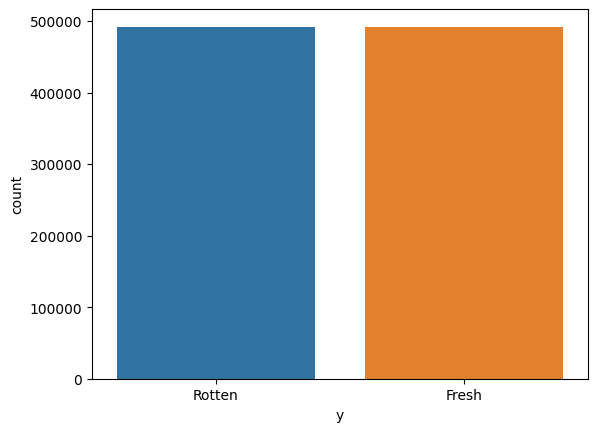

In [ ]:
sns.countplot(x=train_df['y'])
plt.show()

In [ ]:
train_aug = ih.Augment_parallel(train_df, ratio=0.1)

Augment_function - code-pid: 0 - len-data: 2
Augment_function - code-pid: 1 - len-data: 3


In [ ]:
df = pd.concat(train_aug)
df.reset_index(drop=True, inplace=True)
df

,x,y
0,premise domestic disturbance interests better ...,Rotten
1,willis self evidently capable kicking asses me...,Rotten
2,sometimes oscar gets exactly right,Fresh
3,sxrehoIsihg dmoetsci dsiturabnce JiterHeWs bet...,Rotten
4,impecably produced ultimately uninspired movie...,Rotten
5,french physician jean martin charcot hypnotize...,Rotten
6,"Impecabcyl shown, utilmatley feElutyoG film c*...",Rotten


In [ ]:
res = []
for k in train_aug:
    res.append(train_aug[k])
pd.concat(res)

In [ ]:
import time
import os
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
mp.cpu_count()

2

In [ ]:
def func(x, y, ratio):
    for i in range(10_000_000):
        for j in range(10):
            a = 10
    print('Hello')

In [ ]:
util_time = []
for i in range(10):
    start = time.time()
    func([1,2,3,4], [1,2,3,4])
    func([1,2,3,4], [1,2,3,4])
    end = time.time()
    util_time.append(end-start)
print(np.mean(util_time))

In [ ]:
util_time = []
for i in range(10):
    start = time.time()
    p1 = mp.Process(target=func, args=([1,2,3,4], [1,2,3,4]))
    p1.start()
    p1.join()
    p2 = mp.Process(target=func, args=([1,2,3,4], [1,2,3,4]))
    p2.start()
    p2.join()
    end = time.time()
    util_time.append(end-start)
print(np.mean(util_time))

1.7075833559036255


In [ ]:
util_time = []
# pool = mp.Pool(2)

for i in range(10):
    start = time.time()
    # p1 = mp.Process(target=func, args=([1,2,3,4], [1,2,3,4]))
    # p2 = mp.Process(target=func, args=([1,2,3,4], [1,2,3,4]))
    # p1.start()
    # p2.start()
    # p1.join()
    # p2.join()
    with mp.Pool(2) as exe:
        # perform calculations
        results = exe.map(func, [1,2,3,4])
    end = time.time()
    util_time.append(end-start)
print(np.mean(util_time))

In [ ]:
with mp.Pool(2) as threadpool:
    start = time.time()
    threadpool.apply(func, ([1,2,3], [1,2,3], 2))
    threadpool.apply(func, ([1,2,3], [1,2,3], 2))
    print("Thread pool:", time.time() - start)

Hello
Hello
Thread pool: 8.64829421043396


In [ ]:

x = ["The quick brown fox jumps over the lazy dog.",
     "GSN International is a woman-owned minority business. GSN International stands behind every product or service provided.", 
     "National Geographic is a world-renowned media brand that is known for its exceptional visual storytelling, captivating documentaries, and thought-provoking journalism.", 
     "NLP algorithms enable machines to understand, interpret, and generate human language, making it possible for chatbots, voice assistants, and automated language translation systems to function effectively.", 
     "Machine Learning is a field of computer science that involves developing algorithms and statistical models that enable computer systems to automatically learn and improve from experience.", 
     "It is a massive, hot ball of plasma that generates energy through nuclear fusion and has a powerful magnetic field that affects the entire Solar System.", 
     "The relationship between a mother and her child is often considered to be one of the most important and influential bonds in a person's life.",
     "My brother and I share a strong bond of love and friendship that has only grown stronger over the years.", 
     "Genetics is the study of how traits and characteristics are inherited from one generation to another through DNA.", 
     "Football, also known as soccer in some parts of the world, is a sport that is enjoyed by millions of people around the globe.", 
     "Carpets are a popular flooring option in homes and offices because of their warmth, comfort, and aesthetic appeal.", 
     "His legacy continues to inspire and influence people around the world, both in the realm of martial arts and in popular culture more broadly."]


for t in x:
    print(t)
    print('### Word_Substitute_spelling')
    print(ih.Word_Substitute_spelling(t))
    print('### Word_Insert_w2v')
    print(ih.Word_Insert_w2v(t))
    print('### Word_Substitute_w2v')
    print(ih.Word_Substitute_w2v(t))
    print('### Word_Insert_fasttext')
    print(ih.Word_Insert_fasttext(t))
    print('### Word_Substitute_fasttext')
    print(ih.Word_Substitute_fasttext(t))
    print('### Word_Substitute_wordNet')
    print(ih.Word_Substitute_wordNet(t))
    print('### Word_Substitute_ppdb')
    print(ih.Word_Substitute_ppdb(t))
    print('### Keyboard')
    print(ih.Keyboard(t))
    print('### Char_Random_Insert')
    print(ih.Char_Random_Insert(t))
    print('### Char_Random_Substitute')
    print(ih.Char_Random_Substitute(t))
    print('### Char_Random_Swap')
    print(ih.Char_Random_Swap(t))
    print('### Char_Random_Delete')
    print(ih.Char_Random_Delete(t))
    print('### Word_Split')
    print(ih.Word_Split(t))
    print('### Back_Translation')
    print(ih.Back_Translation(t))




'The quick brown fox jumps over the lazy dog.'

In [ ]:
x = ["The quick brown fox jumps over the lazy dog.",
     "GSN International is a woman-owned minority business. GSN International stands behind every product or service provided.", 
     "National Geographic is a world-renowned media brand that is known for its exceptional visual storytelling, captivating documentaries, and thought-provoking journalism.", 
     "NLP algorithms enable machines to understand, interpret, and generate human language, making it possible for chatbots, voice assistants, and automated language translation systems to function effectively.", 
     "Machine Learning is a field of computer science that involves developing algorithms and statistical models that enable computer systems to automatically learn and improve from experience.", 
     "It is a massive, hot ball of plasma that generates energy through nuclear fusion and has a powerful magnetic field that affects the entire Solar System.", 
     "The relationship between a mother and her child is often considered to be one of the most important and influential bonds in a person's life.",
     "My brother and I share a strong bond of love and friendship that has only grown stronger over the years.", 
     "Genetics is the study of how traits and characteristics are inherited from one generation to another through DNA.", 
     "Football, also known as soccer in some parts of the world, is a sport that is enjoyed by millions of people around the globe.", 
     "Carpets are a popular flooring option in homes and offices because of their warmth, comfort, and aesthetic appeal.", 
     "His legacy continues to inspire and influence people around the world, both in the realm of martial arts and in popular culture more broadly."]
y = ['fresh', 'rotten', 'rotten', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 
     'rotten', 'fresh', 'rotten', 'fresh']
out = ih.Upsample_less_number_class(x, y)
len(out[out['y'] == 'fresh']), len(out[out['y'] == 'rotten'])

{'fresh': 1.5, 'rotten': 3.0}


(12, 12)

In [ ]:
out

,x,y
0,"It is a massive, hot ball of plasma that gener...",fresh
1,"Football, also known as soccer in some parts o...",fresh
2,Genetics is the study of how traits and charac...,rotten
3,Genetics is the study of how traits and charac...,rotten
4,GSN International is a woman-owned minority bu...,rotten
5,Carpets are a popular flooring option in homes...,rotten
6,His legacy continues to inspire and influence ...,fresh
7,"NLP algorithms enable machines to understand, ...",fresh
8,My brother and I share a strong bond of love a...,fresh
9,The quick brown fox jumps over the lazy dog.,fresh


In [ ]:
def get_review_of(movie_title, movies):
    return movies[movies['movie_title'] == movie_title]

## Split for first task

In [ ]:
# X_rem, X_test, y_rem, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42, stratify=y_data)
# X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.1, random_state=42, stratify=y_rem)
# print(f"Train: {len(y_train)} ({(len(y_train)/len(y_data))*100:.0f}%)")
# print(f"Val: {len(y_val)} ({(len(y_val)/len(y_data))*100:.0f}%)")
# print(f"Test: {len(y_test)} ({(len(y_test)/len(y_data))*100:.0f}%)")

In [ ]:
# normalizing my_score for movies in train, test and validation dataset seperately